In [21]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
import clahe

# Load ResNet50 model for feature extraction
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from skrebate import ReliefF

import numpy as np
import cv2
import os
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



In [2]:
def load_yolo():
    path_to_cfg = "/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.cfg" 
    path_to_weights = "/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/yolo/yolov3.weights"
    net = cv2.dnn.readNet(path_to_weights, path_to_cfg)
    layers_names = net.getLayerNames()
    
    # Handling different versions of OpenCV which may return different formats
    try:
        output_layers = [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    except Exception:
        output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers()]

    return net, output_layers

def yolo_detect(net, image, output_layers, confidence_threshold=0.3):
    height, width, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    boxes = []
    confidences = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_id == 0:  # Person class
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                if x >= 0 and y >= 0 and (x + w) <= width and (y + h) <= height:
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))

    # Select the largest vertical box based on area if any boxes were detected
    if boxes:
        largest_box = max(boxes, key=lambda b: b[2] * b[3])  # b[2]*b[3] is the area of the box (w*h)
        largest_confidence = confidences[boxes.index(largest_box)]
        return [largest_box], [largest_confidence]
    return [], []  # Return empty lists if no boxes detected


In [27]:
# def extract_features(images):
#     # Load ResNet50 model
#     resnet_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
#     processed_images = []

#     for img in images:
#         if img is not None and img.size > 0:  # Ensure the image is not empty
#             resized_img = cv2.resize(img, (224, 224))
#             processed_images.append(resized_img)
    
#     if not processed_images:
#         return np.array([])  # Return empty array if no images to process
    
#     images_array = np.array(processed_images)
#     images_array = preprocess_input(images_array)
#     features = resnet_model.predict(images_array)
    
#     return features


In [14]:
import numpy as np
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2



def load_model(trainable=False, num_classes=None):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    if trainable:
        # Adding trainable layers
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(num_classes, activation='softmax')(x)  # Change for the number of classes

    model = Model(inputs=base_model.input, outputs=x)

    if trainable:
        # Freeze all convolutional ResNet layers
        for layer in base_model.layers:
            layer.trainable = False

    return model

def train_cnn(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        epochs=30,
                        batch_size=10,
                        validation_data=(X_val, y_val))
    return history

def extract_features(images, model):
    processed_images = []

    for img in images:
        if img is not None and img.size > 0:
            resized_img = cv2.resize(img, (224, 224))
            processed_images.append(resized_img)

    if not processed_images:
        return np.array([])

    images_array = np.array(processed_images)
    images_array = preprocess_input(images_array)
    features = model.predict(images_array)

    return features



In [13]:
def load_data_for_cnn(root_folder, net, output_layers, test_size=0.2, random_state=42):
    images = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

    # Load images and labels
    for player_name in os.listdir(root_folder):
        player_folder = os.path.join(root_folder, player_name)
        if os.path.isdir(player_folder):
            for img_file in os.listdir(player_folder):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(player_folder, img_file)
                    img = cv2.imread(img_path)
                    if img is None or img.size == 0:
                        print(f"Failed to load image {img_path}.")
                        continue

                    boxes, _ = yolo_detect(net, img, output_layers)
                    for box in boxes:
                        x, y, w, h = box
                        if w > 0 and h > 0:
                            cropped_img = img[y:y+h, x:x+w]
                            if cropped_img.size > 0:
                                resized_img = cv2.resize(cropped_img, (224, 224))
                                images.append(resized_img)
                                labels.append(player_name)

    if not images:
        print("No valid images found in dataset.")
        return None, None, None, None  # Return None if no images

    # Convert images and labels to numpy arrays
    images = np.array(images)
    images = preprocess_input(images)  # Preprocess images as required by ResNet50

    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    labels = to_categorical(labels)  # Convert labels to one-hot encoding

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=test_size, random_state=random_state)

    return X_train, y_train, X_val, y_val, encoder

In [16]:
# Create an instance of CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def load_and_preprocess_data(root_folder, net, output_layers,model):
    images = []
    labels = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")
    
    for player_name in os.listdir(root_folder):
        player_folder = os.path.join(root_folder, player_name)
        if os.path.isdir(player_folder):
            for img_file in os.listdir(player_folder):
                if img_file.lower().endswith(valid_extensions):
                    img_path = os.path.join(player_folder, img_file)
                    img = cv2.imread(img_path)
                    if img is None or img.size == 0:
                        print(f"Failed to load image {img_path}.")
                        continue

                    boxes, _ = yolo_detect(net, img, output_layers)

                    for box in boxes:
                        x, y, w, h = box
                        if w > 0 and h > 0:  # Check if box dimensions are valid
                            cropped_img = img[y:y+h, x:x+w]

                            # # Apply CLAHE
                            # lab = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2LAB)
                            # l, a, b = cv2.split(lab)
                            # l = clahe.apply(l)
                            # processed_img = cv2.merge([l, a, b])
                            # processed_img = cv2.cvtColor(processed_img, cv2.COLOR_LAB2BGR)

                            if cropped_img.size > 0:  # Check if the cropped image is not empty
                                images.append(cropped_img)
                                labels.append(player_name)

    if not images:
        print("No valid images found in dataset.")
        return np.array([]), np.array([]), None  # Return empty arrays if no images
    
    # Extract features using the pre-trained model
    features = extract_features(images,model)
    
    if features.size == 0:
        print("No features extracted.")
        return np.array([]), np.array([]), None  # Return empty arrays if no features extracted
    
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    
    return features, encoded_labels, encoder

# SVC

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - accuracy: 0.2209 - loss: 2.5075 - val_accuracy: 0.5904 - val_loss: 1.1978
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step - accuracy: 0.5306 - loss: 1.2720 - val_accuracy: 0.7410 - val_loss: 0.8580
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.6607 - loss: 0.9086 - val_accuracy: 0.7952 - val_loss: 0.6607
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.7227 - loss: 0.7747 - val_accuracy: 0.8313 - val_loss: 0.5780
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.7708 - loss: 0.6782 - val_accuracy: 0.8976 - val_loss: 0.4753
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.8197 - loss: 0.5770 - val_accuracy: 0.9157 - val_loss: 0.3937
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step - accuracy: 0.8501 - loss: 0.4732 - val_accuracy: 0.9157 - val_loss: 0.3562
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.8968 - loss: 0.3970 - val_accu

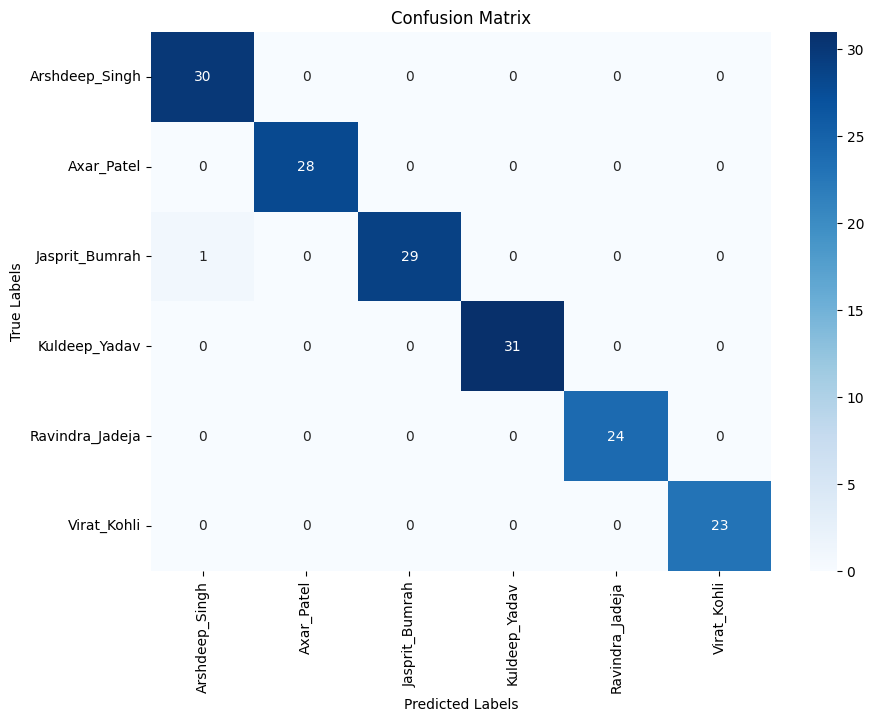

In [22]:
from skrebate import ReliefF
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

def main():
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    num_classes = 6  # Adjust based on your dataset
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load model for training
    model = load_model(trainable=True, num_classes=num_classes)

    # Dummy load function - replace with your data loading mechanism
    X_train, y_train, X_val, y_val, encoder = load_data_for_cnn(output_frame_folder, net, output_layers)  # Adjusted to correctly unpack five values
    if X_train is None:
        print("Failed to load training data.")
        return
    # Train the model
    train_cnn(model, X_train, y_train, X_val, y_val)

    # Convert model to feature extractor
    model = load_model()  # Reload as feature extractor
    
    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if X.size == 0:
        print("No features were extracted.")
        return

    # Print the number of features extracted per image
    num_features = X.shape[1]  # Since X is likely to be (num_samples, num_features)
    print(f'Number of features extracted: {num_features}')

    # Applying ReliefF
    # fs = ReliefF(n_neighbors=20, n_features_to_select=100)  # You can adjust these parameters
    # fs.fit(X_train, y_train)

    # Get the feature rankings
    # print("Feature rankings:", fs.feature_importances_)
    
    # Transform the feature matrices to include only the most important features as per ReliefF
    # X_train_transformed = fs.transform(X_train)
    # X_test_transformed = fs.transform(X_test)

    # Train SVM with selected features
    svm_classifier = SVC(kernel='rbf', C= 10, gamma= 'scale', probability=True)
    svm_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = svm_classifier.score(X_train, y_train)
    test_accuracy = svm_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Generate classification report
    y_pred = svm_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # # Save the SVM model and label encoder
    # joblib.dump(svm_classifier, 'svm_player_recognition.pkl')
    # joblib.dump(encoder, 'svm_label_encoder.pkl')

if __name__ == "__main__":
    main()


##### with learning curve and cross validation

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 649ms/step
Training Accuracy: 1.0
Testing Accuracy: 0.9879518072289156
Cross-validation scores: [0.93975904 0.94545455 0.96363636 0.94545455 0.9030303 ]
Mean cross-validation score: 0.9394669587440673


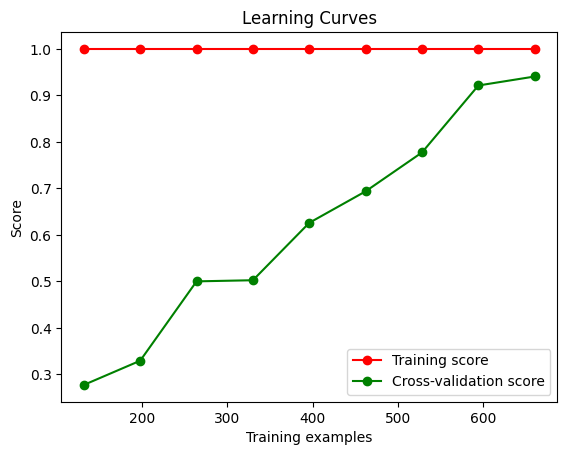

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       1.00      0.97      0.98        30
     Axar_Patel       0.97      1.00      0.98        28
 Jasprit_Bumrah       1.00      1.00      1.00        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      0.96      0.98        24
    Virat_Kohli       0.96      1.00      0.98        23

       accuracy                           0.99       166
      macro avg       0.99      0.99      0.99       166
   weighted avg       0.99      0.99      0.99       166



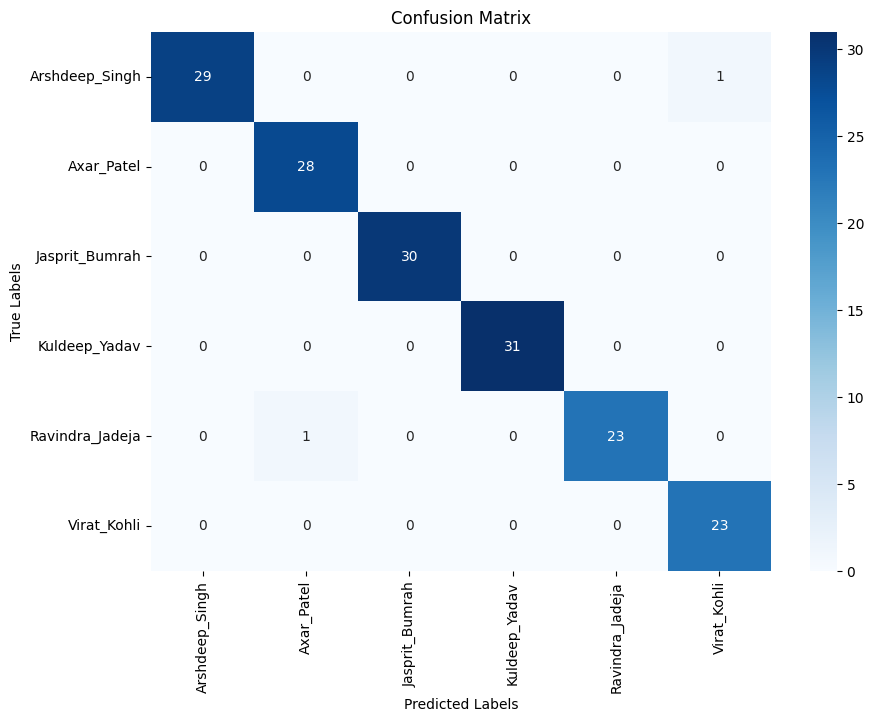

In [53]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train SVM
    svm_classifier = SVC(kernel='linear', probability=True)
    svm_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = svm_classifier.score(X_train, y_train)
    test_accuracy = svm_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Cross-validation
    cv_scores = cross_val_score(svm_classifier, X, y, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        svm_classifier, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    plot_learning_curves(train_sizes, train_scores, test_scores)

    # Generate classification report
    y_pred = svm_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the SVM model and label encoder
    joblib.dump(svm_classifier, 'svm_player_recognition.pkl')
    joblib.dump(encoder, 'svm_label_encoder.pkl')

def plot_learning_curves(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

if __name__ == "__main__":
    main()


##### with learning curve and hyperparameter tuning

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 641ms/step
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.95
Training Accuracy: 1.0
Testing Accuracy: 0.9939759036144579


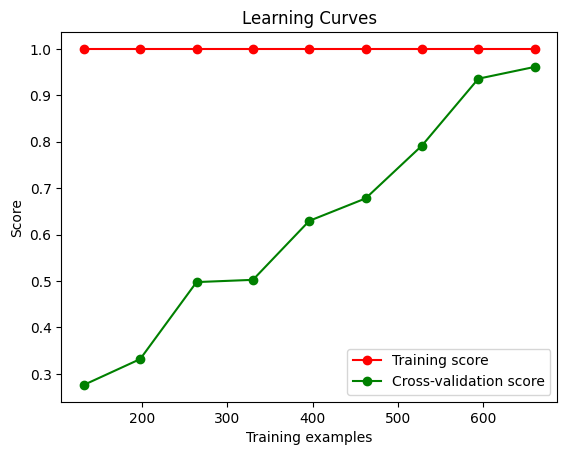

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      1.00      0.98        30
     Axar_Patel       1.00      1.00      1.00        28
 Jasprit_Bumrah       1.00      0.97      0.98        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      1.00      1.00        24
    Virat_Kohli       1.00      1.00      1.00        23

       accuracy                           0.99       166
      macro avg       0.99      0.99      0.99       166
   weighted avg       0.99      0.99      0.99       166



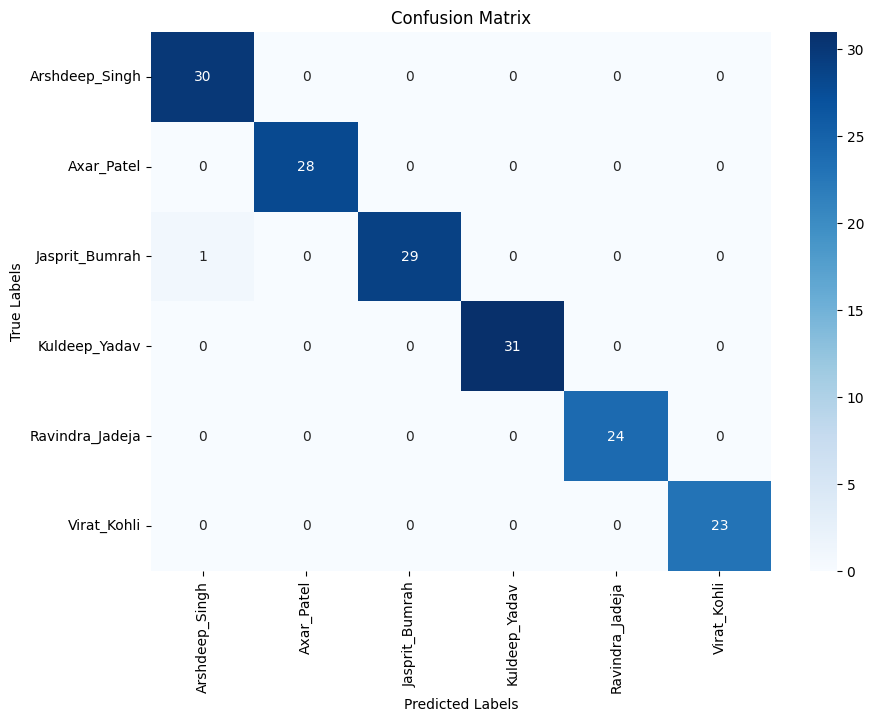

In [55]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Set up the parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'kernel': ['linear', 'rbf'],  # Type of kernel
        'gamma': ['scale', 'auto']  # Kernel coefficient
    }

    # Create an SVC classifier object
    svm = SVC(probability=True)

    # Create a GridSearchCV object
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Print out the best parameters and best score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    # Retrieve the best model from the grid search
    best_svm = grid_search.best_estimator_
    
    # Evaluate the best model on the training set
    training_accuracy = best_svm.score(X_train, y_train)
    print(f"Training Accuracy: {training_accuracy}")

    # Evaluate the best model on the test set
    test_accuracy = best_svm.score(X_test, y_test)
    print(f"Testing Accuracy: {test_accuracy}")

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        best_svm, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    plot_learning_curves(train_sizes, train_scores, test_scores)

    # Generate classification report
    y_pred = best_svm.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the best SVM model and label encoder
    joblib.dump(best_svm, 'best_svm_player_recognition.pkl')
    joblib.dump(encoder, 'svm_label_encoder.pkl')

def plot_learning_curves(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

if __name__ == "__main__":
    main()


### Random Forest

26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 700ms/step
Training Accuracy: 1.0
Testing Accuracy: 0.9578313253012049
Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.94      0.97      0.95        30
     Axar_Patel       1.00      0.96      0.98        28
 Jasprit_Bumrah       1.00      0.90      0.95        30
  Kuldeep_Yadav       0.97      1.00      0.98        31
Ravindra_Jadeja       0.92      0.92      0.92        24
    Virat_Kohli       0.92      1.00      0.96        23

       accuracy                           0.96       166
      macro avg       0.96      0.96      0.96       166
   weighted avg       0.96      0.96      0.96       166



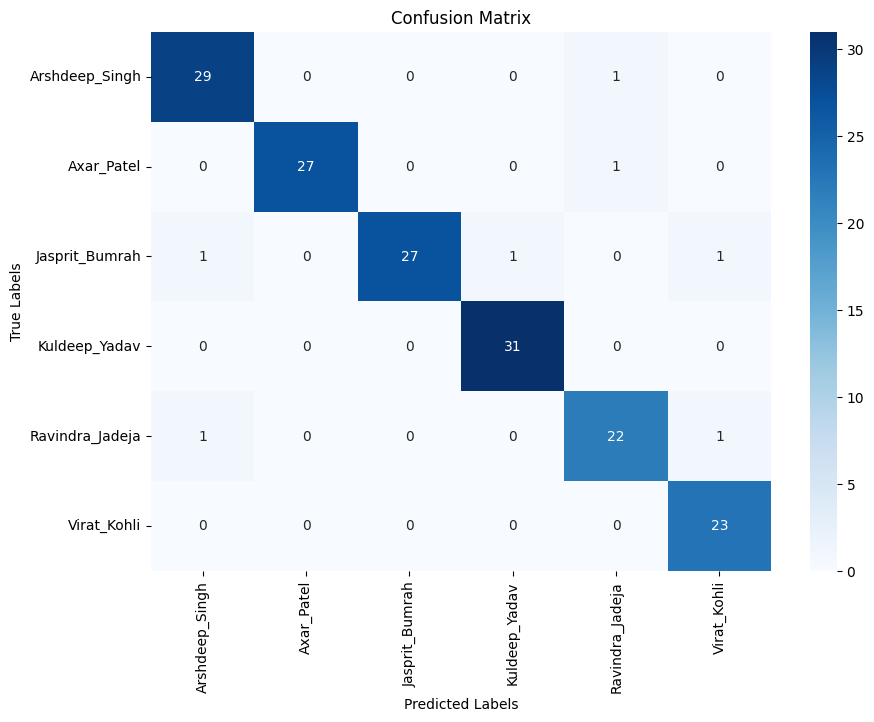

In [36]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Random Forest
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = rf_classifier.score(X_train, y_train)
    test_accuracy = rf_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Generate classification report
    y_pred = rf_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the Random Forest model and label encoder
    joblib.dump(rf_classifier, 'rf_player_recognition.pkl')
    joblib.dump(encoder, 'rf_label_encoder.pkl')

if __name__ == "__main__":
    main()


### Decision Tree

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 651ms/step
Training Accuracy: 1.0
Testing Accuracy: 0.6626506024096386
Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.67      0.53      0.59        30
     Axar_Patel       0.56      0.64      0.60        28
 Jasprit_Bumrah       0.73      0.73      0.73        30
  Kuldeep_Yadav       0.76      0.81      0.78        31
Ravindra_Jadeja       0.57      0.54      0.55        24
    Virat_Kohli       0.67      0.70      0.68        23

       accuracy                           0.66       166
      macro avg       0.66      0.66      0.66       166
   weighted avg       0.66      0.66      0.66       166



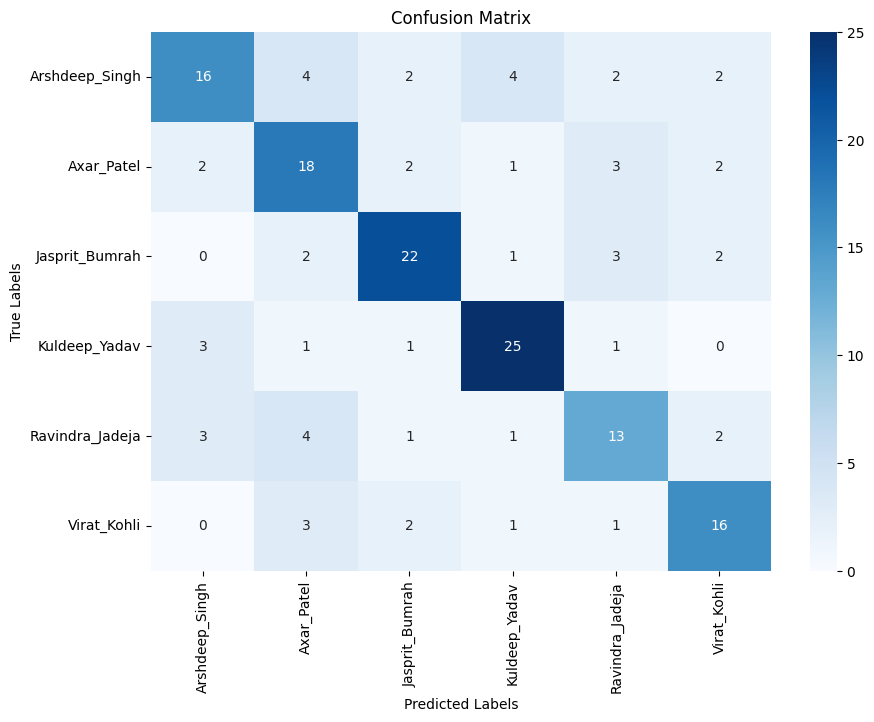

In [37]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers,model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Decision Tree
    dt_classifier = DecisionTreeClassifier(max_depth=None, random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = dt_classifier.score(X_train, y_train)
    test_accuracy = dt_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Generate classification report
    y_pred = dt_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the Decision Tree model and label encoder
    joblib.dump(dt_classifier, 'dt_player_recognition.pkl')
    joblib.dump(encoder, 'dt_label_encoder.pkl')

if __name__ == "__main__":
    main()


# KNN

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 623ms/step
Training Accuracy: 0.9575757575757575
Testing Accuracy: 0.9698795180722891
Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      0.97      0.97        30
     Axar_Patel       0.90      1.00      0.95        28
 Jasprit_Bumrah       1.00      0.97      0.98        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      0.88      0.93        24
    Virat_Kohli       0.96      1.00      0.98        23

       accuracy                           0.97       166
      macro avg       0.97      0.97      0.97       166
   weighted avg       0.97      0.97      0.97       166



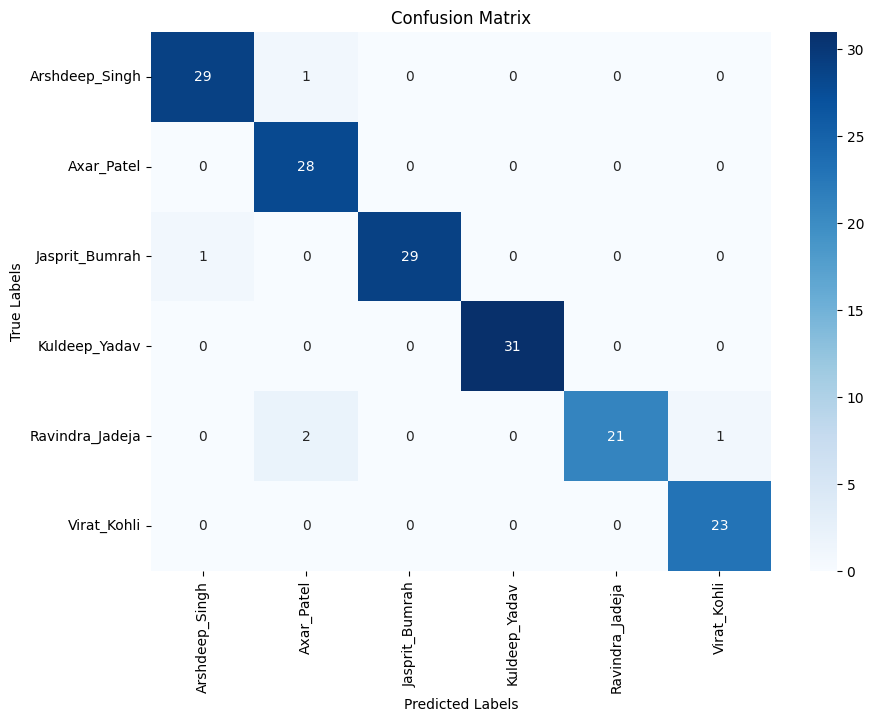

In [38]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = knn_classifier.score(X_train, y_train)
    test_accuracy = knn_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Generate classification report
    y_pred = knn_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the KNN model and label encoder
    joblib.dump(knn_classifier, 'knn_player_recognition.pkl')
    joblib.dump(encoder, 'knn_label_encoder.pkl')

if __name__ == "__main__":
    main()


##### with learning curve and cross validation

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 663ms/step
Training Accuracy: 0.9575757575757575
Testing Accuracy: 0.9698795180722891
Cross-validation scores: [0.84939759 0.92727273 0.96363636 0.88484848 0.81818182]
Mean cross-validation score: 0.8886673968601679


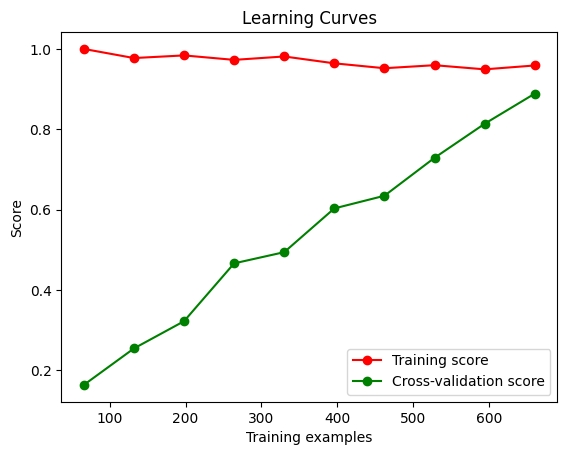

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.97      0.97      0.97        30
     Axar_Patel       0.90      1.00      0.95        28
 Jasprit_Bumrah       1.00      0.97      0.98        30
  Kuldeep_Yadav       1.00      1.00      1.00        31
Ravindra_Jadeja       1.00      0.88      0.93        24
    Virat_Kohli       0.96      1.00      0.98        23

       accuracy                           0.97       166
      macro avg       0.97      0.97      0.97       166
   weighted avg       0.97      0.97      0.97       166



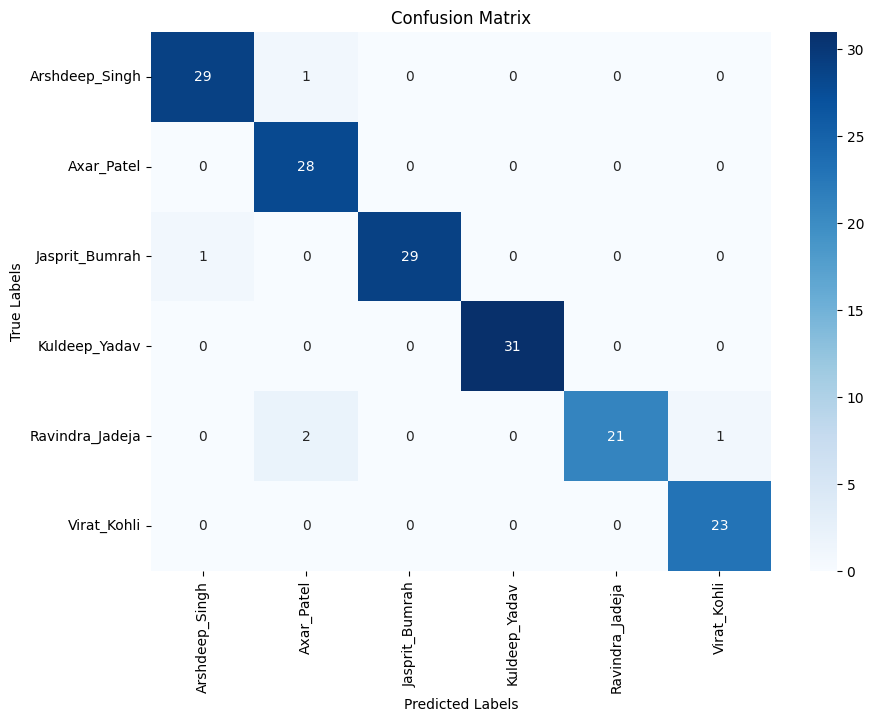

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = knn_classifier.score(X_train, y_train)
    test_accuracy = knn_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Cross-validation
    cv_scores = cross_val_score(knn_classifier, X, y, cv=5)
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        knn_classifier, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    plot_learning_curves(train_sizes, train_scores, test_scores)

    # Generate classification report
    y_pred = knn_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the KNN model and label encoder
    joblib.dump(knn_classifier, 'knn_player_recognition.pkl')
    joblib.dump(encoder, 'knn_label_encoder.pkl')

def plot_learning_curves(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

if __name__ == "__main__":
    main()


##### with learning curve and hyperparameter tuning

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 683ms/step
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation score: 0.94
Training Accuracy: 1.0
Testing Accuracy: 0.9698795180722891


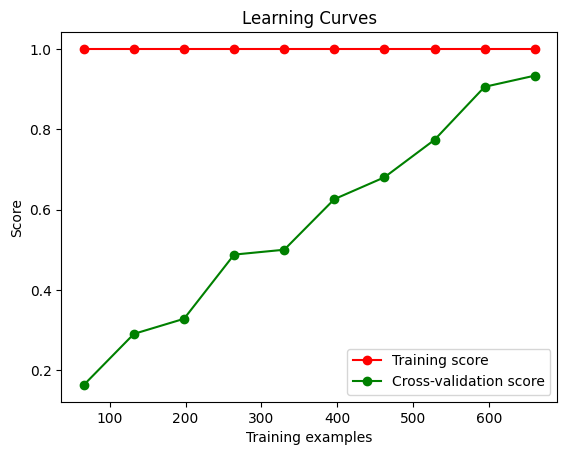

Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.91      0.97      0.94        30
     Axar_Patel       1.00      1.00      1.00        28
 Jasprit_Bumrah       1.00      0.90      0.95        30
  Kuldeep_Yadav       0.97      1.00      0.98        31
Ravindra_Jadeja       0.96      0.96      0.96        24
    Virat_Kohli       1.00      1.00      1.00        23

       accuracy                           0.97       166
      macro avg       0.97      0.97      0.97       166
   weighted avg       0.97      0.97      0.97       166



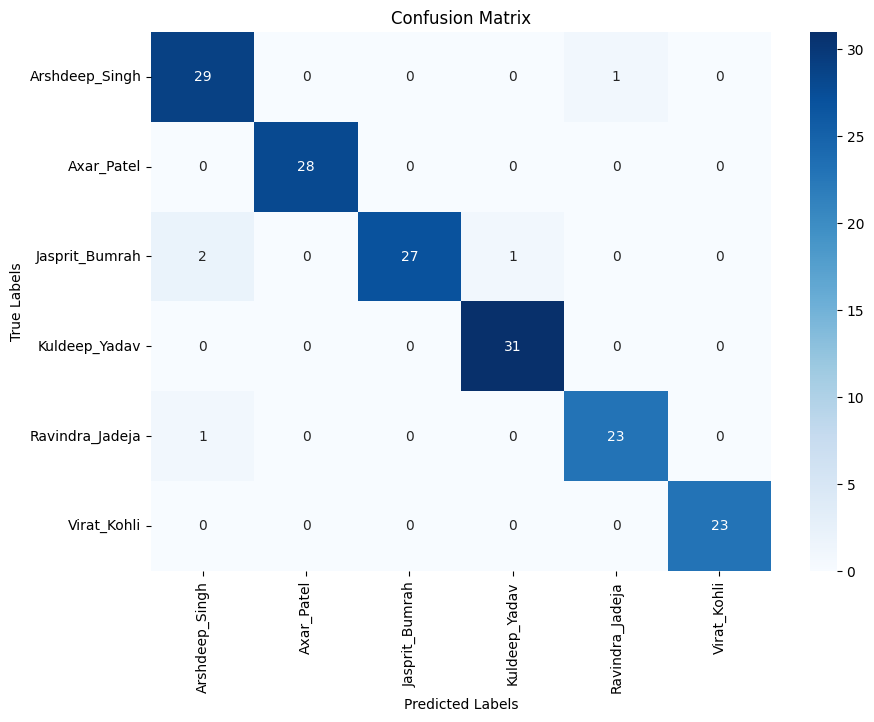

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Set up the parameter grid
    param_grid = {
        'n_neighbors': range(1, 31, 2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    # Create a KNeighbors classifier object
    knn = KNeighborsClassifier()

    # Create a GridSearchCV object
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Print out the best parameters and best score
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

    # Retrieve the best model from the grid search
    best_knn = grid_search.best_estimator_
    
    # Evaluate the best model on the training set
    training_accuracy = best_knn.score(X_train, y_train)
    print(f"Training Accuracy: {training_accuracy}")

    # Evaluate the best model on the test set
    test_accuracy = best_knn.score(X_test, y_test)
    print(f"Testing Accuracy: {test_accuracy}")

    # Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        best_knn, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 10))
    
    plot_learning_curves(train_sizes, train_scores, test_scores)

    # Generate classification report
    y_pred = best_knn.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # # Save the best KNN model and label encoder
    # joblib.dump(best_knn, 'best_knn_player_recognition.pkl')
    # joblib.dump(encoder, 'label_encoder.pkl')

def plot_learning_curves(train_sizes, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

if __name__ == "__main__":
    main()


### Gradient Boost Machine

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 621ms/step
Training Accuracy: 1.0
Testing Accuracy: 0.9036144578313253
Classification Report:
                 precision    recall  f1-score   support

 Arshdeep_Singh       0.82      0.93      0.87        30
     Axar_Patel       0.92      0.82      0.87        28
 Jasprit_Bumrah       0.93      0.93      0.93        30
  Kuldeep_Yadav       0.94      1.00      0.97        31
Ravindra_Jadeja       0.90      0.75      0.82        24
    Virat_Kohli       0.92      0.96      0.94        23

       accuracy                           0.90       166
      macro avg       0.91      0.90      0.90       166
   weighted avg       0.91      0.90      0.90       166



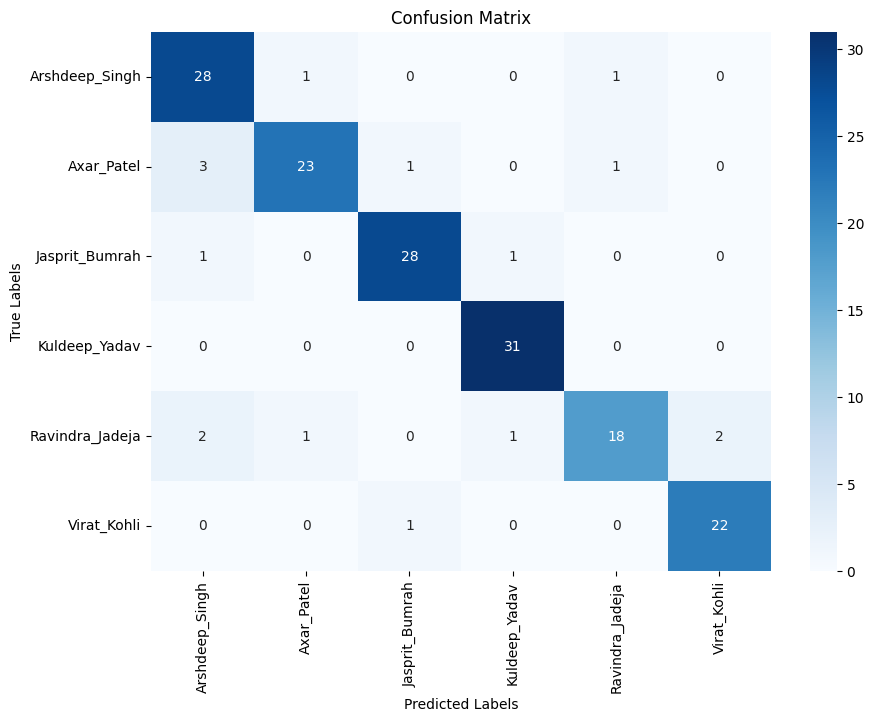

In [39]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

def main():
    # Load YOLO model for detection
    net, output_layers = load_yolo()

    # Load the ResNet model for feature extraction
    model = load_model()
    
    output_frame_folder = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/extracted_frames'
    
    # Load and preprocess data, now passing the model for feature extraction
    X, y, encoder = load_and_preprocess_data(output_frame_folder, net, output_layers, model)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Gradient Boosting Machine
    gbm_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbm_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    train_accuracy = gbm_classifier.score(X_train, y_train)
    test_accuracy = gbm_classifier.score(X_test, y_test)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")

    # Generate classification report
    y_pred = gbm_classifier.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=encoder.classes_)
    print("Classification Report:")
    print(report)

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Save the GBM model and label encoder
    joblib.dump(gbm_classifier, 'gbm_player_recognition.pkl')
    joblib.dump(encoder, 'gbm_label_encoder.pkl')

if __name__ == "__main__":
    main()


## Inference

In [51]:
import cv2
import numpy as np
import os
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
import joblib

# Load YOLO model and output layers
net, output_layers = load_yolo()

# Function to extract frames from a video
def extract_frames_for_prediction(video_path, net, output_layers, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = total_frames // num_frames if total_frames > num_frames else 1
    frame_ids = [int(interval * i) for i in range(num_frames)]
    frames = []

    frame_count = 0
    while frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count in frame_ids:
            # Apply YOLO detection to each frame
            boxes, _ = yolo_detect(net, frame, output_layers)
            if boxes:  # Check if there is at least one detection
                x, y, w, h = boxes[0]  # largest detected box 
                cropped_frame = frame[y:y+h, x:x+w]
                frames.append(cropped_frame)
            else:
                print(f"No valid detections at frame {frame_count}.")
        frame_count += 1

    cap.release()
    return frames

# Prediction function adapted for video
def predict_person(video_path, model, svc_model, label_encoder):
    frames = extract_frames_for_prediction(video_path, net, output_layers)
    if not frames:
        return "No frames to analyze or no valid detections."

    # Get features for all frames using the extract_features function
    features = extract_features(frames, model)
    
    for feature in features:
        # Ensure each feature is properly reshaped for predict_proba
        probabilities = svc_model.predict_proba([feature])[0]  # Use list wrapping for single sample
        predicted_class_index = np.argmax(probabilities)
        predicted_player = label_encoder.inverse_transform([predicted_class_index])[0]
        confidence = probabilities[predicted_class_index]
        print(f"Detected person: {predicted_player} with confidence: {confidence:.2f}")

# Example usage
video_path = '/Users/pubudusenarathne/Downloads/Hybrid_Spatio_Temporal_Model_For_Gait_Analysis/test_video/1.mov'
# Load the pre-trained ResNet model
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
# Load trained SVC model and label encoder
svc_model = joblib.load('svm_player_recognition.pkl')
label_encoder = joblib.load('svm_label_encoder.pkl')
predict_person(video_path, model, svc_model, label_encoder)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
Detected person: Arshdeep_Singh with confidence: 0.56
Detected person: Arshdeep_Singh with confidence: 0.27
Detected person: Arshdeep_Singh with confidence: 0.41
Detected person: Kuldeep_Yadav with confidence: 0.41
Detected person: Arshdeep_Singh with confidence: 0.70
Detected person: Arshdeep_Singh with confidence: 0.34
Detected person: Arshdeep_Singh with confidence: 0.35
Detected person: Arshdeep_Singh with confidence: 0.24
Detected person: Jasprit_Bumrah with confidence: 0.35
Detected person: Kuldeep_Yadav with confidence: 0.42
